In [56]:
import sys
import yfinance as yf
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import ParameterSampler
from joblib import Parallel, delayed
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import VECM
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

In [31]:
import warnings
warnings.filterwarnings("ignore", message=".*no associated frequency information.*")

In [127]:
def download_prices(tickers, start="2010-01-01"):
    df = yf.download(tickers, start=start, end="2025-05-23",auto_adjust=True, progress=False)[['Close']]
    df.dropna(inplace=True)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(1)
    return df

In [128]:
def rolling_zscore(series, thr_window):
    m = series.rolling(thr_window).mean()
    s = series.rolling(thr_window).std(ddof=1)
    return (series - m) / s

In [129]:
def estimate_half_life(spread):
    spread = spread.dropna()
    lagged = spread.shift(1).dropna()
    delta = spread.diff().dropna()
    df = pd.DataFrame({'y': delta, 'x': lagged.loc[delta.index]})
    beta = np.linalg.lstsq(df['x'].values.reshape(-1, 1), df['y'].values, rcond=None)[0][0]
    halflife = -np.log(2) / beta
    return max(1, round(halflife))

In [130]:
def generate_signal(z, long_z, short_z):
    sig, state = pd.Series(0, index=z.index), 0
    prev = z.shift(1)
    for t in z.index:
        c, p = z.at[t], prev.at[t]
        if pd.notna(c) and pd.notna(p):
            if state == 0 and p >= long_z and c < long_z:
                state = 1  # Enter Long
            elif state == 0 and p <= short_z and c > short_z:
                state = -1  # Enter Short
            elif state == 1 and c < short_z and c >= 0:
                state = 0  # Exit Long only
            elif state == 1 and c > short_z:
                state = -1  # Exit Long and Flip to Short
            elif state == -1 and c > long_z and c <= 0:
                state = 1  # Exit Short and enter long
            elif state == 1 and c <= 0:
                state = 0
        sig.at[t] = state
    return sig.astype(int)

In [131]:
def backtest_alpha_scaled_basket(df, beta, signal, fee_per_trade=0.001):
    """
    df     : DataFrame with cointegrated assets (e.g., ['SPY','QQQ','XLK'])
    beta   : vecm_res.beta[:, 0] → cointegration vector (np.array)
    signal : pd.Series of +1 / -1 / 0 for long/short/flat on the spread basket
    """
    basket_ret = df.pct_change().dropna() @ beta

    # Align signal
    signal = signal.reindex(df.index).fillna(0).astype(int)
    pos = signal.shift(1).reindex(basket_ret.index).fillna(0).astype(int)
    strat_ret = pos * basket_ret

    # Apply fees
    abs_sum = np.sum(np.abs(beta))
    per_trade_cost = fee_per_trade * abs_sum  # like slippage × turnover per rebalance
    entries = (pos.shift(1) != pos) & (pos != 0)
    strat_ret.loc[entries] -= per_trade_cost

    # Metrics
    equity = (1+strat_ret).cumprod()
    days = len(basket_ret)
    total = equity.iloc[-1] - 1
    cagr     = equity.iloc[-1]**(252/days) - 1
    ann_vol  = strat_ret.std(ddof=1) * np.sqrt(252)
    sharpe   = (strat_ret.mean() / strat_ret.std() * np.sqrt(252)) if strat_ret.std() != 0 else np.nan
    max_dd   = (equity / equity.cummax() - 1).min()
    nz       = strat_ret[strat_ret != 0]
    hit_rate = (nz > 0).sum() / len(nz) if len(nz) else np.nan

    # Hold durations
    changes = pos != pos.shift(1)
    dates   = pos.index[changes]
    vals    = pos[changes]
    hold, prev, ent = [], 0, None
    hold, prev, ent = [], 0, None
    for d, v in zip(dates, vals):
        if v != prev:
            if prev != 0 and ent is not None:
                hold.append((d - ent).days)
            ent = d if v != 0 else None
        prev = v
    if prev != 0 and ent is not None:
        hold.append((pos.index[-1] - ent).days)
    avg_hold = np.mean(hold) if hold else np.nan

    return {
        'Total Return':  total,
        'CAGR':          cagr,
        'Ann Vol':       ann_vol,
        'Sharpe':        sharpe,
        'Max Drawdown':  max_dd,
        'Trades':        int(entries.sum()),
        'Hit Rate':      hit_rate,
        'Avg Hold Days': avg_hold,
        'Data Points':   days
    }

In [132]:
def get_coint_params(df, det_order=1, k_ar_diff=2):
  model = VECM(df, k_ar_diff=2, coint_rank=1, deterministic='co')  # 'co' for NONE constant in cointegration eq
  vecm_res = model.fit()
  beta = vecm_res.beta
  alpha = vecm_res.alpha
  spread = df @ vecm_res.beta[:, 0]
  return alpha, beta, spread

In [138]:
def process_cointegration_triplet(tickers):
    df    = download_prices(tickers)
    dates = df.index

    results = []
    test_start = dates.min() + relativedelta(years=3)
    while True:
        test_end = test_start + relativedelta(years=1) - pd.Timedelta(days=1)
        if test_end > dates.max():
            break
        train_start = test_start - relativedelta(years=3)
        train_end   = test_start - pd.Timedelta(days=1)

        train_df = df.loc[train_start:train_end]
        test_df  = df.loc[test_start:test_end]

        # ——— Randomized tuning on the TRAIN window ———
        alpha_train, beta_train, spread_train = get_coint_params(train_df)
        adf_p = adfuller(spread_train.dropna())[1]
        print(f"ADF p-val = {adf_p:.3f}")

        alpha_train_mags = np.abs(alpha_train).flatten()
        alpha_train_norm = alpha_train_mags / alpha_train_mags.sum()
        beta_train_scaled = beta_train.flatten() * alpha_train_norm  # scale cointegration vector by responsiveness
        spread_test_adj = pd.Series(test_df @ beta_train_scaled, index=test_df.index)
        spread_test_adj.plot(kind='hist', bins=50, title="Spread Distribution")
        spread_test_adj.autocorr(lag=1)
        spread_train_adj = pd.Series(train_df @ beta_train_scaled, index=train_df.index)

        # ——— Evaluate best params on the TEST window ———
        spread_ma = spread_test_adj.rolling(window=10).mean()
        sig_t = (spread_ma.diff() > 0).astype(int) * 2 - 1  # +1 if trend up, -1 if trend down
        print(sig_t.value_counts())
        mets  = backtest_alpha_scaled_basket(test_df, beta_train_scaled, sig_t)

        mets.update({
            'train_start': train_start.date(),
            'train_end':   train_end.date(),
            'test_start':  test_start.date(),
            'test_end':    test_end.date(),
        })
        results.append(mets)

        test_start = test_end + pd.Timedelta(days=1)

    return results

In [139]:
tickers = ['SPY','QQQ','XLK']

ADF p-val = 0.005
 1    153
-1     99
Name: count, dtype: int64
ADF p-val = 0.447
-1    129
 1    122
Name: count, dtype: int64
ADF p-val = 0.060
 1    153
-1     98
Name: count, dtype: int64
ADF p-val = 0.004
 1    154
-1     99
Name: count, dtype: int64
ADF p-val = 0.077
 1    185
-1     67
Name: count, dtype: int64
ADF p-val = 0.028
 1    139
-1    112
Name: count, dtype: int64
ADF p-val = 0.001
 1    180
-1     72
Name: count, dtype: int64
ADF p-val = 0.000
-1    176
 1     75
Name: count, dtype: int64
ADF p-val = 0.015
 1    168
-1     85
Name: count, dtype: int64
ADF p-val = 0.286
-1    157
 1     94
Name: count, dtype: int64
ADF p-val = 0.003
-1    169
 1     82
Name: count, dtype: int64
ADF p-val = 0.005
-1    188
 1     64
Name: count, dtype: int64


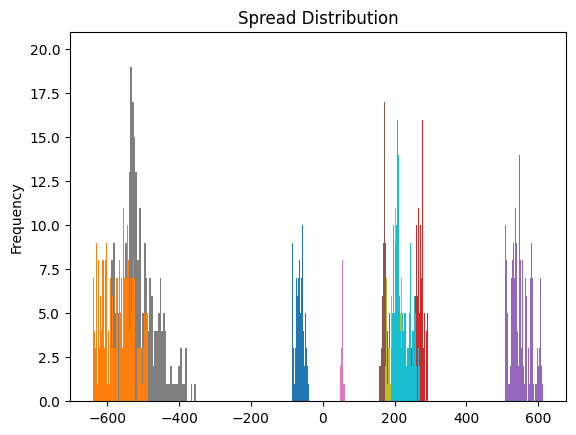

In [140]:
results = process_cointegration_triplet(tickers)

In [141]:
results_df = pd.DataFrame(results)

In [142]:
results_df

,Total Return,CAGR,Ann Vol,Sharpe,Max Drawdown,Trades,Hit Rate,Avg Hold Days,Data Points,train_start,train_end,test_start,test_end
0,-0.044745,-0.044920,0.021903,-2.087183,-0.046040,44,0.462151,8.204545,251,2010-01-04,2013-01-03,2013-01-04,2014-01-03
1,-0.016311,-0.016441,0.029999,-0.537636,-0.042324,29,0.456000,12.413793,250,2011-01-04,2014-01-03,2014-01-04,2015-01-03
2,0.002655,0.002676,0.034386,0.094844,-0.033062,38,0.504000,9.447368,250,2012-01-04,2015-01-03,2015-01-04,2016-01-03
3,0.006752,0.006752,0.131228,0.116570,-0.153195,29,0.507937,12.551724,252,2013-01-04,2016-01-03,2016-01-04,2017-01-03
4,0.021477,0.021564,0.118346,0.239075,-0.124466,28,0.450199,12.964286,251,2014-01-04,2017-01-03,2017-01-04,2018-01-03
5,-0.032103,-0.032356,0.059041,-0.527662,-0.050314,35,0.464000,10.371429,250,2015-01-04,2018-01-03,2018-01-04,2019-01-03
6,-0.000878,-0.000882,0.020178,-0.033664,-0.018131,20,0.525896,18.050000,251,2016-01-04,2019-01-03,2019-01-04,2020-01-03
7,0.545539,0.550932,0.505448,1.119302,-0.373522,23,0.536000,15.608696,250,2017-01-04,2020-01-03,2020-01-04,2021-01-03
8,-0.032031,-0.032031,0.031866,-1.005684,-0.038676,32,0.464286,11.343750,252,2018-01-04,2021-01-03,2021-01-04,2022-01-03
9,0.006804,0.006859,0.171107,0.125240,-0.139332,29,0.512000,12.517241,250,2019-01-04,2022-01-03,2022-01-04,2023-01-03
